# How to use mcFano feature selection tool

In [1]:
import scanpy as sc

from BigSur.feature_selection import mcfano_feature_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sc.set_figure_params(dpi=100)

## Summary of BigSur usage:

Setup adata

In [2]:
adata = sc.read_10x_h5('../../../Data/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5') # read in adata
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=3)
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/Users/emmanueldollinger/miniconda3/envs/FanoFeatureSelection/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/emmanueldollinger/miniconda3/envs/FanoFeatureSelection/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Run function

In [3]:
mcfano_feature_selection(adata, layer='counts') # Replace sc.pp.highly_variable_genes(adata) call
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

Using 0.01 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


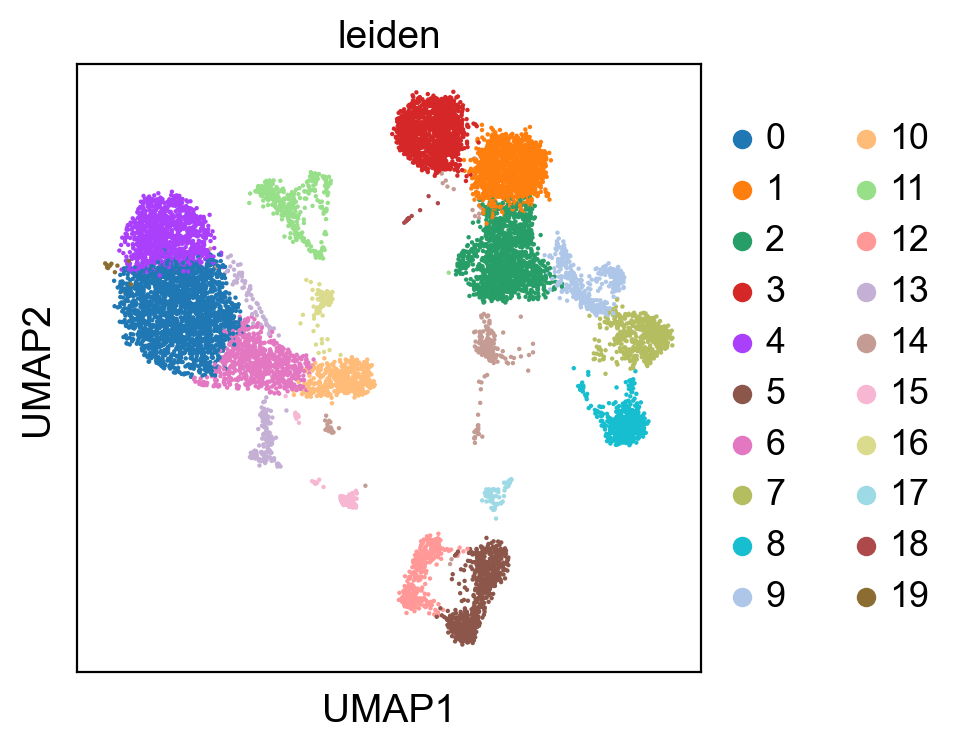

In [4]:
sc.pl.umap(adata, color='leiden')

## Checks for adata input

Reimport adata for demonstration

In [5]:
adata = sc.read_10x_h5('../../../Data/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5') # read in adata
adata.var_names_make_unique()
adata.layers['counts'] = adata.X.copy()

/Users/emmanueldollinger/miniconda3/envs/FanoFeatureSelection/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/emmanueldollinger/miniconda3/envs/FanoFeatureSelection/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Default usage: specify adata and layer of counts

We require filtering genes before usage:

In [6]:
mcfano_feature_selection(adata, layer='counts')

Using 0.01 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


Exception: Zero means were found, run QC steps before calculating mFF.

In [7]:
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
adata.shape

(11893, 22300)

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

We require passing counts, not normalized data:

In [10]:
mcfano_feature_selection(adata, layer='X')

Using 0.01 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


Exception: This function takes raw counts, normalized data was passed.

Default scanpy pipeline:

In [11]:
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

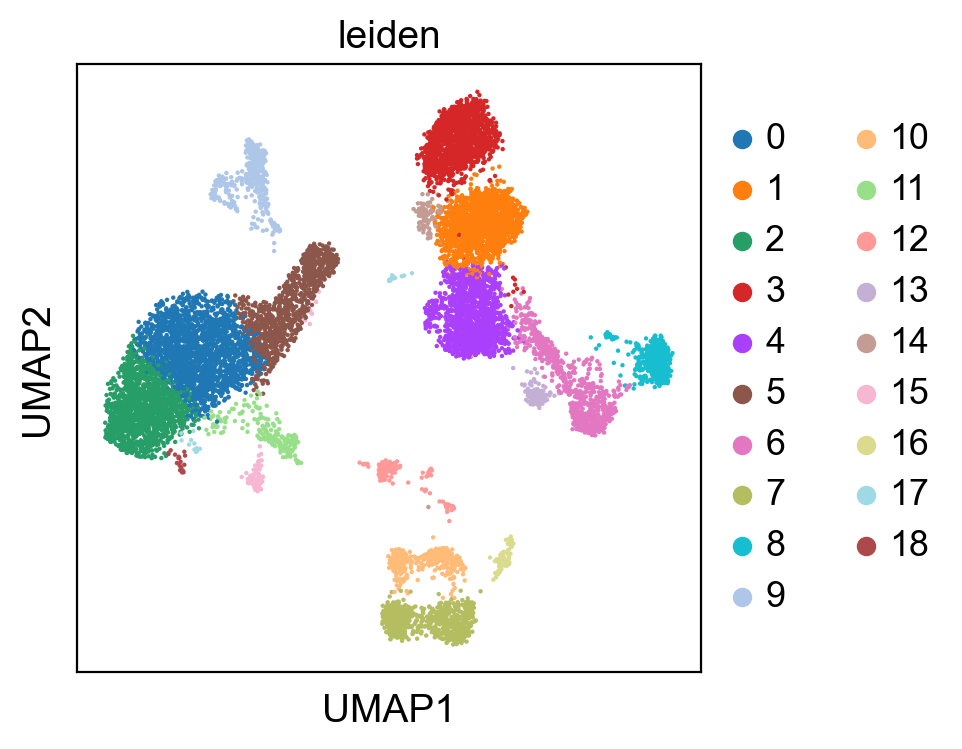

In [12]:
sc.pl.umap(adata, color='leiden')

Default mcFano usage:

In [13]:
mcfano_feature_selection(adata, layer='counts') # Replace sc.pp.highly_variable_genes(adata) call
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

Using 0.01 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


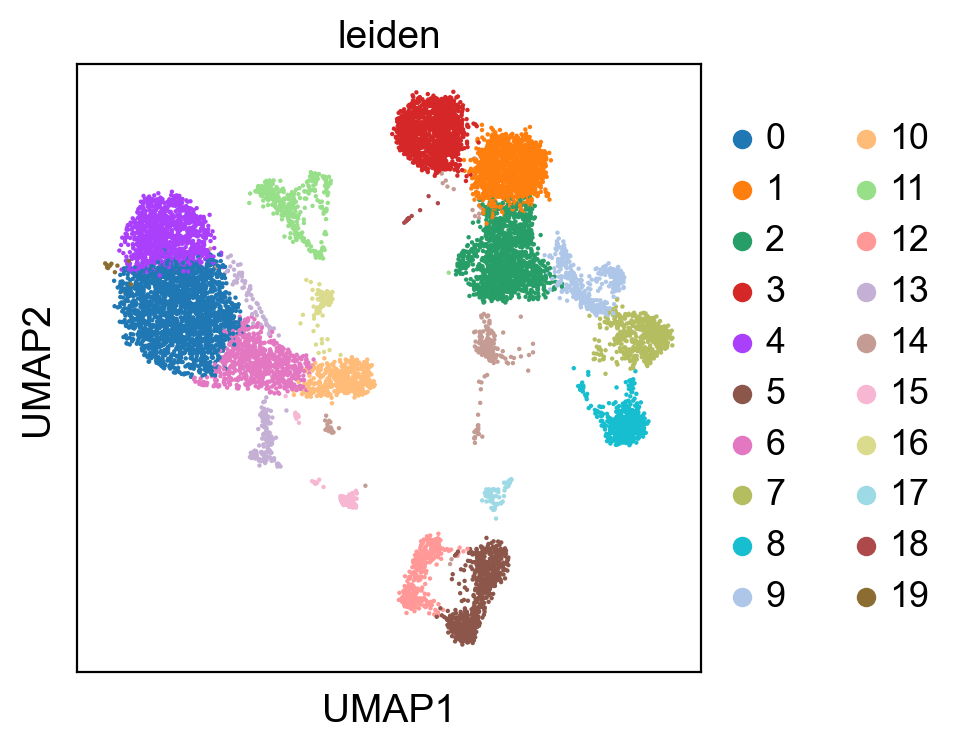

In [14]:
sc.pl.umap(adata, color='leiden')

## Advanced usage:

### Tool has 3 verbosity levels: none, a little and a lot

In [15]:
mcfano_feature_selection(adata, layer='counts', verbose=0)

In [16]:
mcfano_feature_selection(adata, layer='counts', verbose=1)

Using 0.01 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


KeyboardInterrupt: 

In [ ]:
mcfano_feature_selection(adata, layer='counts', verbose=2)

### User can pick whether to limit the number of genes called as highly variable:

In [ ]:
mcfano_feature_selection(adata, layer='counts', verbose=1, n_genes_for_PCA=400)

In [ ]:
adata.var['highly_variable'].sum()

Note that by default if there is a conflict between the cutoffs and the number of genes requested by the user, the cutoffs win:

In [ ]:
mcfano_feature_selection(adata, layer='counts', verbose=1, n_genes_for_PCA=10000)

In [ ]:
adata.var['highly_variable'].sum()

The p value cutoff can be disabled:

In [ ]:
mcfano_feature_selection(adata, layer='counts', verbose=1, p_val_cutoff=None)

We do NOT recommend turning off the p value criterion; however if considering different celltypes, p value cutoff isn't necessary (and can be faster computationally): 

In [ ]:
mcfano_feature_selection(adata, layer='counts', verbose=2)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata, color='leiden')

In [ ]:
mcfano_feature_selection(adata, layer='counts', p_val_cutoff=None, verbose=2)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
#sc.tl.leiden(adata) not recalculate leiden to show difference

In [ ]:
sc.pl.umap(adata, color='leiden')

UMAPs are similar

### Fitting coefficient of variation

CV is the only parameter in our model. We've found that using a CV of 0.5 is usually sufficient, but we also provide a way to fit CV:

Note that fitting CV is only necessary if the dataset being considered is cells that are similar (i.e. intra celltype analysis). Fitting CV for inter celltype analysis will take very long and probably won't work (function is designed to throw an error). 

In [ ]:
PBMC=sc.read('../../../Data/10kPBMC_working.h5ad')

PBMC.uns['log1p']['base'] = None

In [ ]:
CD4 = PBMC[PBMC.obs['GroupedIdents'].isin(['CD4+ T Cells'])].copy()

sc.pp.filter_genes(CD4, min_cells=3)
mcfano_feature_selection(CD4, layer='counts', cv=None) # Fit CV

In [ ]:
?mcfano_feature_selection

Package list:

In [ ]:
!cat environment.yml